
--- Sample RFM Scores ---
     job_id                                              title  Recency  \
0    921716                              Marketing Coordinator        2   
1   1829192                  Mental Health Therapist/Counselor        8   
2  10998357                        Assitant Restaurant Manager        3   
3  23221523  Senior Elder Law / Trusts and Estates Associat...        7   
4  35982263                                 Service Technician        1   

   Frequency  Monetary  RFM_Score  
0       20.0   38480.0        9.0  
1        1.0   83200.0        6.0  
2        8.0   55000.0       10.0  
3       16.0  157500.0       10.0  
4        3.0   70000.0        9.0  


/tmp/ipython-input-31625115.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_matrix = df.groupby(['R_quartile','F_quartile']).mean(numeric_only=True)['Monetary'].unstack()


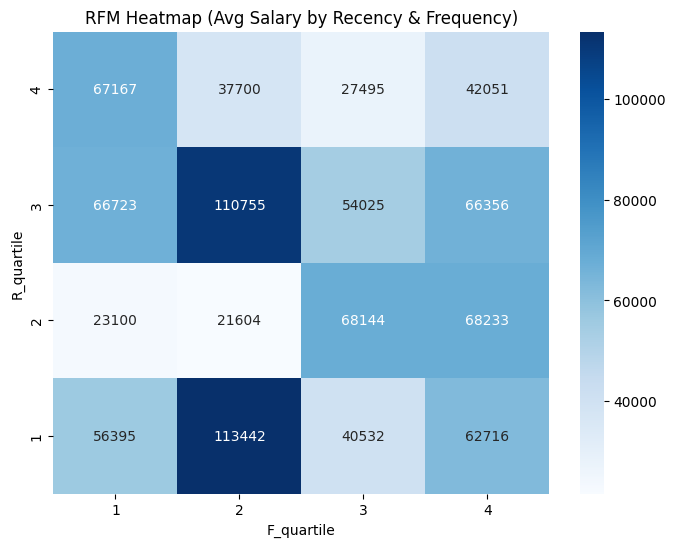

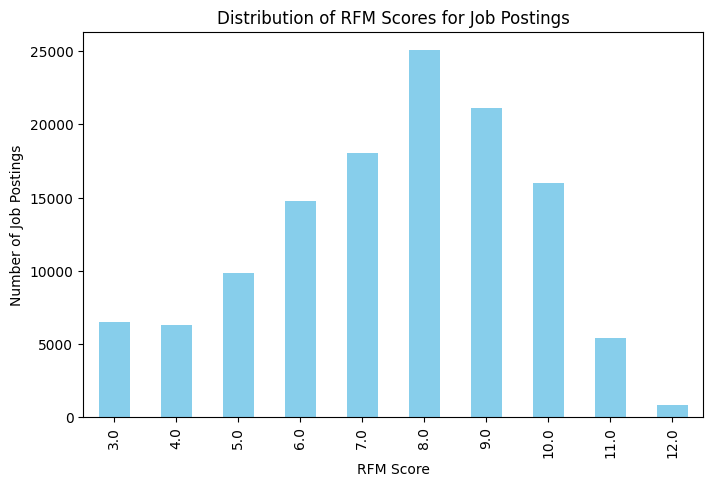

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load dataset
df = pd.read_csv("postings.csv")

# Convert listed_time to datetime
df['listed_time'] = pd.to_datetime(df['listed_time'], unit='ms')
max_date = df['listed_time'].max()

# Step 2: Build RFM features
df['Recency'] = (max_date - df['listed_time']).dt.days
df['Frequency'] = df['views'].fillna(0)   # number of views
df['Monetary'] = df['normalized_salary'].fillna(0)

# Step 3: Safe quartile assignment (auto adjust labels)
def safe_qcut(series, q, ascending=True):
    try:
        bins = pd.qcut(series.rank(method="first"), q, duplicates="drop")
        n_bins = bins.cat.categories.size
        labels = list(range(1, n_bins+1))
        if not ascending:
            labels = labels[::-1]
        return pd.qcut(series.rank(method="first"), q, labels=labels, duplicates="drop")
    except Exception as e:
        print(f"qcut error on {series.name}: {e}")
        return pd.Series([None]*len(series), index=series.index)

df['R_quartile'] = safe_qcut(df['Recency'], 4, ascending=False)
df['F_quartile'] = safe_qcut(df['Frequency'], 4, ascending=True)
df['M_quartile'] = safe_qcut(df['Monetary'], 4, ascending=True)

# RFM Score
df['RFM_Score'] = df[['R_quartile','F_quartile','M_quartile']].astype(float).sum(axis=1)

print("\n--- Sample RFM Scores ---")
print(df[['job_id','title','Recency','Frequency','Monetary','RFM_Score']].head())

# Step 4: Heatmap
rfm_matrix = df.groupby(['R_quartile','F_quartile']).mean(numeric_only=True)['Monetary'].unstack()

plt.figure(figsize=(8,6))
sns.heatmap(rfm_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("RFM Heatmap (Avg Salary by Recency & Frequency)")
plt.show()

# Step 5: Bar chart of RFM segments
plt.figure(figsize=(8,5))
df['RFM_Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribution of RFM Scores for Job Postings")
plt.xlabel("RFM Score")
plt.ylabel("Number of Job Postings")
plt.show()
